In [176]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial
from scipy import signal
import requests
from datetime import datetime

%matplotlib inline

In [177]:
def showPlots(plots):
    colors = ['#06d6a0', '#ee6c4d', '#277da1','#5a189a','#f3722c']
    plotCount = 0
    
    for i in range(len(plots)):
        if 'same' not in plots[i] or plots[i]['same'] == False:
            plotCount+=1
            
    fig, axs = plt.subplots(plotCount)
    if plotCount == 1:
        axs = [axs]
    pid = 0
    for i in range(len(plots)):
        if 'same' in plots[i] and plots[i]['same'] == True and pid > 0:
            pid -= 1   
        else:
            axs[pid].grid()
        if 'x' not in plots[i]:
            if 'sc' in plots[i] and plots[i]['sc'] == True:
                axs[pid].scatter(plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
            else:
                axs[pid].plot(plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        else:
            if 'sc' in plots[i] and plots[i]['sc'] == True:
                axs[pid].scatter(plots[i]['x'][:len(plots[i]['data'])], plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
            else:
                axs[pid].plot(plots[i]['x'][:len(plots[i]['data'])], plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])

        
        axs[pid].legend(loc = 'upper right')
        
        pid+=1

In [178]:
api_key = "dk6g1w736tm81f51qhr9re"

In [256]:
def gen_request_str(currency, endPoint, data = 'assets', data_points = 100):
    #print(endPoint)
    return 'https://api.lunarcrush.com/v2?data='+str(data)+'&key='+api_key+'&symbol='+str(currency)+\
        '&data_points='+str(data_points)+'&end='+str(endPoint)

In [257]:
def stampNow():
    return datetime.now().timestamp()
def getStats(currency, data_points = 100, endPoint = stampNow()):
    response = requests.get(gen_request_str('BTC', endPoint = endPoint, data_points=data_points))
    if response.status_code == 200:
        print('Got it')
    elif response.status_code == 404:
        print('WRONG REQUEST')
    return response

In [264]:
class Plot:
    def __init__(self):
        self.data = []

    def addPoint(self, data):
        if data is not None:
            self.data.append(data)
        else:
            if len(self.data) == 0:
                self.data.append(-1)
                print("bad point")
            else:
                self.data.append(self.data[len(self.data)-1])
            
    def getData(self):
        return self.data
    
class CryptPlot(Plot):
    def __init__(self):
        super(CryptPlot, self).__init__()

In [272]:
class CurrencyStats:
    def __init__(self):
        pass
    
def getCurrencyStatsByResponse(response):
    time_stamps = response.json()['data'][0]['timeSeries']
    #candle stats
    def getCandle(time_stamp):
        return time_stamp['open'], time_stamp['close'], time_stamp['low'], time_stamp['high']
    #get basic scores of plot
    def getScores(time_stamp):
        return time_stamp['reddit_posts_score'], time_stamp['social_score'], time_stamp['social_impact_score'],\
            time_stamp['news'], time_stamp['galaxy_score']
    
    stats = CurrencyStats()

    stats.opens = CryptPlot()
    stats.closes = CryptPlot()
    stats.lows = CryptPlot()
    stats.highs = CryptPlot()

    stats.reddit_scores = CryptPlot()
    stats.social_scores = CryptPlot()
    stats.soc_impact = CryptPlot()
    stats.news_data = CryptPlot()
    stats.galaxy_scores = CryptPlot()

    for i in range(len(time_stamps)):
        candle = getCandle(time_stamps[i])
        scores = getScores(time_stamps[i])

        timestamp = time_stamps[i]['time']
        dt_object = datetime.fromtimestamp(timestamp)
        #print(dt_object)

        stats.opens.addPoint(candle[0])
        stats.closes.addPoint(candle[1])
        stats.lows.addPoint(candle[2])
        stats.highs.addPoint(candle[3])
        #cosials
        stats.reddit_scores.addPoint(scores[0])
        stats.social_scores.addPoint(scores[1])
        stats.soc_impact.addPoint(scores[2])
        stats.news_data.addPoint(scores[3])
        stats.galaxy_scores.addPoint(scores[4])
        
    return stats

def getCurrencyStats(currency, data_points = 100, endPoint = stampNow()):
    response = getStats(currency, data_points = data_points, endPoint = endPoint)
    return getCurrencyStatsByResponse(response)

def plotStats(stats):
    plt.rcParams['figure.figsize'] = [16, 20]
    showPlots([
        {'data': stats.opens.getData(), 'label': 'open'},
        {'data': stats.closes.getData(), 'label': 'close', 'same':True},
        {'data': list(map(lambda x, y: (x+y)*0.5, stats.closes.getData(), stats.opens.getData())), 'label': 'open-close'},
        {'data': stats.lows.getData(), 'label': 'low'},
        {'data': stats.highs.getData(), 'label': 'high', 'same':True},
        {'data': list(map(lambda x, y: (x+y)*0.5, stats.lows.getData(), stats.highs.getData())), 'label': 'low-high'},
        {'data': stats.reddit_scores.getData(), 'label': 'reddit score'},
        {'data': stats.social_scores.getData(), 'label': 'social score'},
        {'data': stats.soc_impact.getData(), 'label': 'social impact'},
        {'data': stats.news_data.getData(), 'label': 'news'},
        {'data': stats.galaxy_scores.getData(), 'label': 'galaxy score'}
    ])

Got it


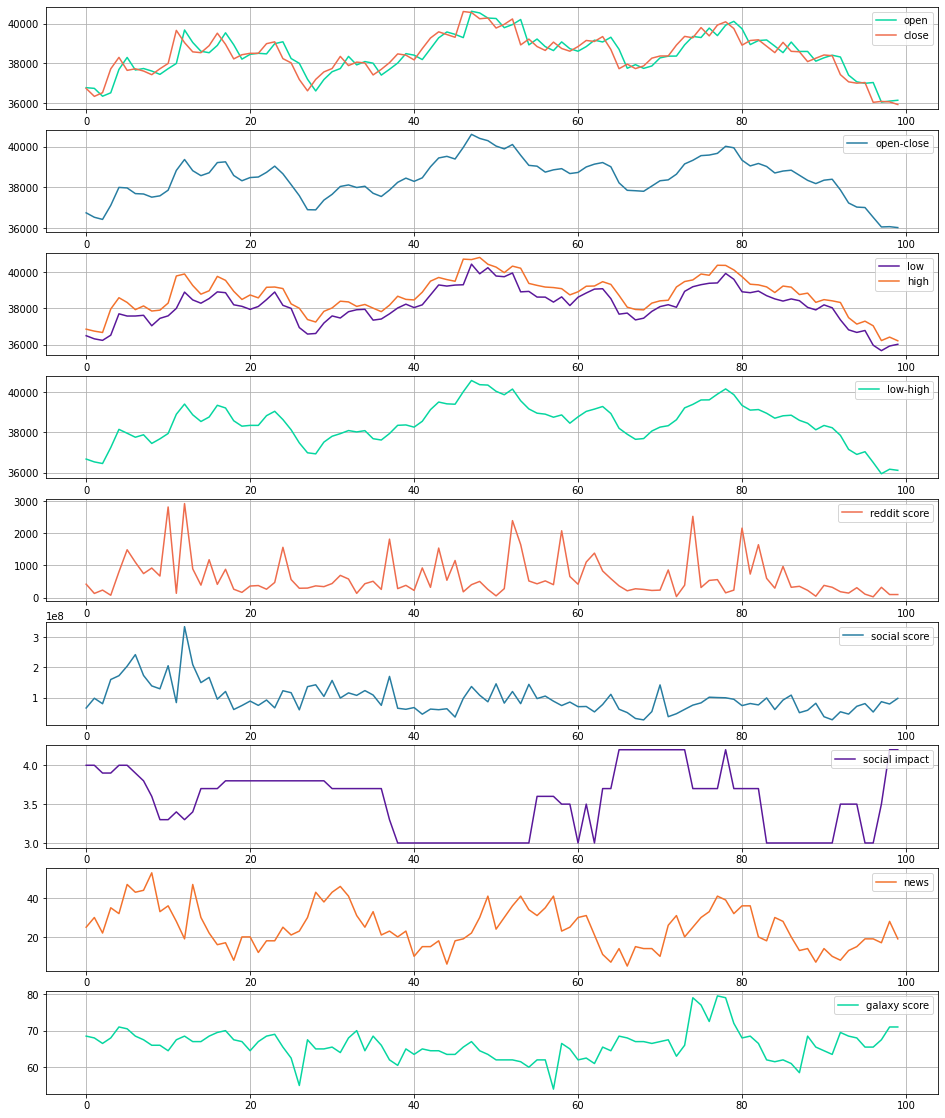

In [273]:
plotStats(getCurrencyStats('ETH'))

In [269]:
#print(datetime.fromtimestamp(1622196000))
#print(datetime.fromtimestamp(1622196000-3600*24))